In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.compose import make_column_transformer
from sklearn.svm import SVR
from sklearn.metrics import (
    make_scorer,
    mean_squared_error,
    mean_absolute_error
)
from sklearn.model_selection import (
    RandomizedSearchCV,
    cross_validate,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from scipy.stats import loguniform
from statsmodels.stats.outliers_influence import OLSInfluence

In [2]:
with open("../../data/processed/train_data.pickle", "rb") as f:
    train_df = pickle.load(f)
    
with open("../../data/processed/test_data.pickle", "rb") as f:
    test_df = pickle.load(f)
    
train_df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,season
285,2,5,jul,sun,93.9,169.7,411.8,12.3,23.4,40,6.3,0.0,0.0,summer
41,4,4,aug,sat,90.2,96.9,624.2,8.9,18.4,42,6.7,0.0,0.0,summer
489,4,4,aug,wed,95.1,141.3,605.8,17.7,20.6,58,1.3,0.0,0.0,summer
398,1,2,aug,sat,93.7,231.1,715.1,8.4,25.9,32,3.1,0.0,0.0,summer
453,4,5,aug,thu,89.4,266.2,803.3,5.6,17.4,54,3.1,0.0,0.0,summer


In [3]:
X_train, y_train = train_df.drop("area", axis=1), train_df["area"]
X_test, y_test = test_df.drop("area", axis=1), test_df["area"]

numeric = ['FFMC','DMC', 'DC', 'ISI', 'temp', 'RH','wind']
categorical = ["X", "Y", "season"]
drop = ["rain", "day", "month"]

column_transformer = make_column_transformer(
    (StandardScaler(), numeric),
    (OneHotEncoder(sparse=False, handle_unknown="ignore"), categorical),
    ("drop", drop)
)

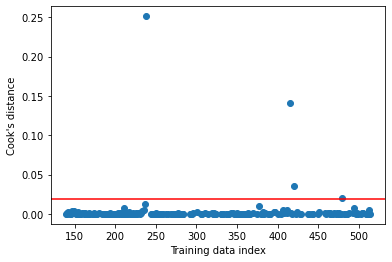

In [4]:
filtered_X_train = X_train[y_train > 0]
filtered_y_train = y_train[y_train > 0]
transformed = column_transformer.fit_transform(filtered_X_train)
categorical_cols = column_transformer.named_transformers_["onehotencoder"].get_feature_names_out().tolist()

preprocessed_X_train = pd.DataFrame(transformed,
                                    columns=numeric + categorical_cols,
                                    index=filtered_X_train.index)
preprocessed_X_train = sm.add_constant(preprocessed_X_train)
    
model = sm.OLS(filtered_y_train, preprocessed_X_train)
model = model.fit()

cooks_distance = OLSInfluence(model).cooks_distance

plt.scatter(preprocessed_X_train.index, cooks_distance[0])
plt.axhline(y=4 / filtered_X_train.shape[0], color="r", linestyle="-")
plt.xlabel("Training data index")
plt.ylabel("Cook's distance")
plt.show()

outliers = pd.DataFrame(cooks_distance[0], index=filtered_X_train.index)
outliers_index = outliers[outliers[0] > 4 / filtered_X_train.shape[0]].index

In [5]:
X_train, y_train = X_train.drop(outliers_index), y_train.drop(outliers_index)

In [6]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [7]:
results= {}
cv = 10

def root_mean_squared_error(y_true, y_pred, **kwargs):

    return np.sqrt(mean_squared_error(y_true, y_pred, **kwargs))

mae_scorer = make_scorer(mean_absolute_error)
rmse_scorer = make_scorer(root_mean_squared_error)

scorers = {
    "mae": mae_scorer,
    "rmse": rmse_scorer
}

In [8]:
svr_pipe = make_pipeline(
    column_transformer,
    SVR()
)

for name, scorer in scorers.items():
    results[f"SVR_{name.upper()}"] = mean_std_cross_val_scores(
        svr_pipe,
        X_train,
        y_train,
        cv=cv,
        scoring=scorer,
        return_train_score=True,
    )

pd.DataFrame(results)

,SVR_MAE,SVR_RMSE
fit_time,0.014 (+/- 0.001),0.013 (+/- 0.000)
score_time,0.004 (+/- 0.001),0.004 (+/- 0.000)
test_score,8.330 (+/- 3.383),21.375 (+/- 10.101)
train_score,8.004 (+/- 0.380),23.290 (+/- 1.087)


In [9]:
params = {
    "svr__C": loguniform(0.9, 2),
    "svr__gamma": loguniform(0.01, 1)
}

In [10]:
random_search = RandomizedSearchCV(
    svr_pipe,
    params,
    cv=cv,
    n_jobs=-1,
    n_iter=50,
    random_state=123,
    scoring=scorers["mae"]
)
    
random_search.fit(X_train, y_train)
    
for name, scorer in scorers.items():
    
    results[f"SVR_Optimized_{name.upper()}"] = mean_std_cross_val_scores(
        random_search,
        X_train,
        y_train,
        cv=cv,
        scoring=scorer,
        return_train_score=True
    )
    
pd.DataFrame(results)

,SVR_MAE,SVR_RMSE,SVR_Optimized_MAE,SVR_Optimized_RMSE
fit_time,0.014 (+/- 0.001),0.013 (+/- 0.000),1.929 (+/- 0.200),1.930 (+/- 0.116)
score_time,0.004 (+/- 0.001),0.004 (+/- 0.000),0.004 (+/- 0.000),0.004 (+/- 0.000)
test_score,8.330 (+/- 3.383),21.375 (+/- 10.101),8.278 (+/- 3.355),21.295 (+/- 10.093)
train_score,8.004 (+/- 0.380),23.290 (+/- 1.087),7.824 (+/- 0.595),23.142 (+/- 1.102)


In [11]:
test_scores = {}

predictions = random_search.best_estimator_.predict(X_test)
test_scores[f"SVR_Optimized_MAE"] = mean_absolute_error(y_test, predictions)
test_scores[f"SVR_Optimized_RMSE"] = root_mean_squared_error(y_test, predictions)

pd.DataFrame(test_scores, index=["Test Score"])

,SVR_Optimized_MAE,SVR_Optimized_RMSE
Test Score,8.686001,28.463946
